<a href="https://colab.research.google.com/github/killcure/segmentation/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#!unzip "/content/drive/MyDrive/Colab Notebooks/Capstone Project/uw-madison-gi-tract-image-segmentation.zip" -d "/content/drive/MyDrive/Colab Notebooks/Capstone Project/data/"

In [3]:
import skimage.io
import numpy as np
import pandas as pd
import re
from glob import glob
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence


In [4]:
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [6]:
DIR_INPUT = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/data/'
train_df = pd.read_csv(f"{DIR_INPUT}/train.csv")
train_df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [7]:
train_df.shape

(115488, 3)

In [8]:
df1 = train_df.pivot_table(values='segmentation',index='id',columns='class',aggfunc='max').reset_index()
df1.head()

class,id,large_bowel,small_bowel,stomach
0,case101_day20_slice_0066,NaN,NaN,32107 5 32371 10 32635 13 32900 15 33165 17 33...
1,case101_day20_slice_0067,NaN,NaN,31313 2 31577 7 31841 10 32105 14 32369 17 326...
2,case101_day20_slice_0068,NaN,NaN,30517 2 30781 6 31046 9 31311 11 31575 15 3184...
3,case101_day20_slice_0069,NaN,NaN,29981 10 30246 13 30511 16 30776 19 31041 21 3...
4,case101_day20_slice_0070,NaN,NaN,28918 9 29182 14 29446 18 29711 21 29976 23 30...


In [9]:
df1.shape
# 16590 ids have ateast one mask

(16590, 4)

In [10]:
np.unique(df1.isna().sum(axis=1), return_counts=True)
# 3201: no null values => all masks present, 1092: 1 null value => 2 masks, 2468 => 2 nulls => only 1 mask
# all sums up to 16590

(array([0, 1, 2]), array([ 3201, 10921,  2468]))

In [11]:
train_df.groupby(['id', 'class'])['segmentation'].count().reset_index().segmentation.value_counts()
# Out of total of 115488 records, we have 33913 NON NAN records, rest 66360 are NAN records

0    81575
1    33913
Name: segmentation, dtype: int64

In [12]:
df2 = train_df.drop_duplicates(subset=['id'])
df2.shape

(38496, 3)

In [13]:
df3 = pd.DataFrame(columns=['id','large_bowel','small_bowel','stomach'])
df3['id'] = df2[~df2['id'].isin(df1['id'])].id.values
df3.shape

(21906, 4)

In [14]:
# All ids with or without masks
data = pd.concat([df1, df3])
data.reset_index(inplace=True, drop=True)
data.head()

,id,large_bowel,small_bowel,stomach
0,case101_day20_slice_0066,NaN,NaN,32107 5 32371 10 32635 13 32900 15 33165 17 33...
1,case101_day20_slice_0067,NaN,NaN,31313 2 31577 7 31841 10 32105 14 32369 17 326...
2,case101_day20_slice_0068,NaN,NaN,30517 2 30781 6 31046 9 31311 11 31575 15 3184...
3,case101_day20_slice_0069,NaN,NaN,29981 10 30246 13 30511 16 30776 19 31041 21 3...
4,case101_day20_slice_0070,NaN,NaN,28918 9 29182 14 29446 18 29711 21 29976 23 30...


In [15]:
data.shape

(38496, 4)

In [16]:
np.unique(data.isna().sum(axis=1), return_counts=True)

(array([0, 1, 2, 3]), array([ 3201, 10921,  2468, 21906]))

In [17]:
data['case'] = data['id'].apply(lambda x: re.findall("\d+",x)[0])
data['day'] = data['id'].apply(lambda x: re.findall("\d+",x)[1])
data['slice'] = data['id'].apply(lambda x: re.findall("\d+",x)[2])

In [18]:
data.head()

,id,large_bowel,small_bowel,stomach,case,day,slice
0,case101_day20_slice_0066,NaN,NaN,32107 5 32371 10 32635 13 32900 15 33165 17 33...,101,20,0066
1,case101_day20_slice_0067,NaN,NaN,31313 2 31577 7 31841 10 32105 14 32369 17 326...,101,20,0067
2,case101_day20_slice_0068,NaN,NaN,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,101,20,0068
3,case101_day20_slice_0069,NaN,NaN,29981 10 30246 13 30511 16 30776 19 31041 21 3...,101,20,0069
4,case101_day20_slice_0070,NaN,NaN,28918 9 29182 14 29446 18 29711 21 29976 23 30...,101,20,0070


In [19]:
path_df = pd.DataFrame(data=glob(f"{DIR_INPUT}/train/*/*/*/*"),columns=['filepath'])
path_df.head()

,filepath
0,/content/drive/MyDrive/Colab Notebooks/Capston...
1,/content/drive/MyDrive/Colab Notebooks/Capston...
2,/content/drive/MyDrive/Colab Notebooks/Capston...
3,/content/drive/MyDrive/Colab Notebooks/Capston...
4,/content/drive/MyDrive/Colab Notebooks/Capston...


In [20]:
path_df['case'] = path_df['filepath'].apply(lambda x: re.findall("\d+",x)[1])
path_df['day'] = path_df['filepath'].apply(lambda x: re.findall("\d+",x)[2])
path_df['slice'] = path_df['filepath'].apply(lambda x: re.findall("\d+",x)[3])
path_df['width'] = path_df['filepath'].apply(lambda x: re.findall("\d+",x)[4])
path_df['height'] = path_df['filepath'].apply(lambda x: re.findall("\d+",x)[5])
path_df['pixel_x'] = path_df['filepath'].apply(lambda x: re.findall("\d+\.\d+",x)[0])
path_df['pixel_y'] = path_df['filepath'].apply(lambda x: re.findall("\d+\.\d+",x)[1])

In [21]:
data = data.merge(path_df, how='left', on=['case','day','slice'])

In [22]:
data.sort_values(by=['case','day','slice'],ignore_index=True, inplace=True)
data.head()

,id,large_bowel,small_bowel,stomach,case,day,slice,filepath,width,height,pixel_x,pixel_y
0,case101_day20_slice_0001,NaN,NaN,NaN,101,20,0001,/content/drive/MyDrive/Colab Notebooks/Capston...,266,266,1.50,1.50
1,case101_day20_slice_0002,NaN,NaN,NaN,101,20,0002,/content/drive/MyDrive/Colab Notebooks/Capston...,266,266,1.50,1.50
2,case101_day20_slice_0003,NaN,NaN,NaN,101,20,0003,/content/drive/MyDrive/Colab Notebooks/Capston...,266,266,1.50,1.50
3,case101_day20_slice_0004,NaN,NaN,NaN,101,20,0004,/content/drive/MyDrive/Colab Notebooks/Capston...,266,266,1.50,1.50
4,case101_day20_slice_0005,NaN,NaN,NaN,101,20,0005,/content/drive/MyDrive/Colab Notebooks/Capston...,266,266,1.50,1.50


In [23]:
data['width'] = data['width'].astype(int)
data['height'] = data['height'].astype(int)

In [24]:
def read_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype("float32")
    return img

In [25]:
def display_images(temp_df):
    temp_df = temp_df.sample(15).reset_index(drop=True)
    plt.figure(figsize=(20,20))
    for i in range(15):
        plt.subplot(5,5,i+1)
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        image = read_img(temp_df.loc[i, 'filepath'])
        plt.imshow(image, cmap='gray')
        plt.title(f"{temp_df.loc[i,'id']}")

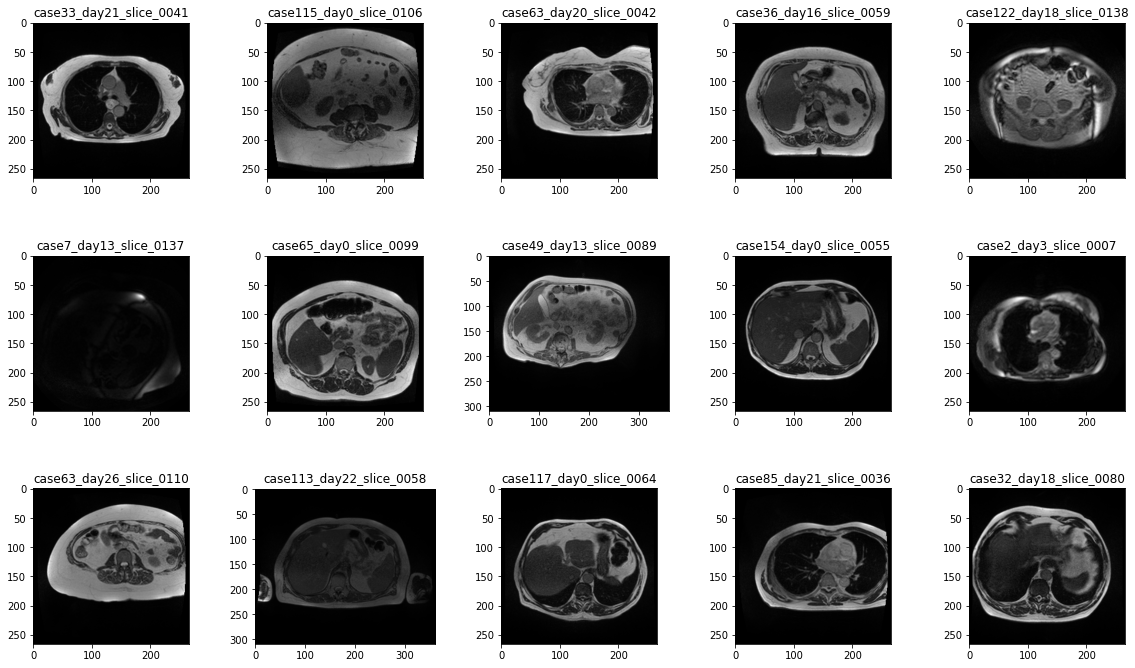

In [26]:
display_images(data)

In [27]:
def mask_from_rle(rle, shape):
    
    if type(rle) == float: # if nan
        return np.zeros(shape[0] * shape[1], dtype=np.uint8).reshape(shape)

    segm = np.asarray(rle.split(), dtype=int)
    start_point = segm[0::2] - 1
    length_point = segm[1::2]
    end_point = start_point + length_point
    case_mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    for start, end in zip(start_point, end_point):
        case_mask[start:end] = 255

    case_mask = case_mask.reshape((shape[0], shape[1]))
    
    return case_mask

In [28]:
def visual(temp_df,size):
    temp_df = temp_df.sample(size).reset_index(drop=True)
    for index in range(size):
        plt.figure(figsize=(20,10))
        image = read_img(temp_df['filepath'].iloc[index])
        plt.subplot(1,4,1)
        plt.imshow(image)
        plt.title("MRI Scan")
        plt.subplot(1,4,2)
        plt.imshow(mask_from_rle(temp_df['large_bowel'].iloc[index],(temp_df['height'].iloc[index],temp_df['width'].iloc[index])))
        plt.title("Large Bowel")
        plt.subplot(1,4,3)
        plt.imshow(mask_from_rle(temp_df['small_bowel'].iloc[index],(temp_df['height'].iloc[index],temp_df['width'].iloc[index])))
        plt.title("Small Bowel")
        plt.subplot(1,4,4)
        plt.imshow(mask_from_rle(temp_df['stomach'].iloc[index],(temp_df['height'].iloc[index],temp_df['width'].iloc[index])))
        plt.title("Stomach")

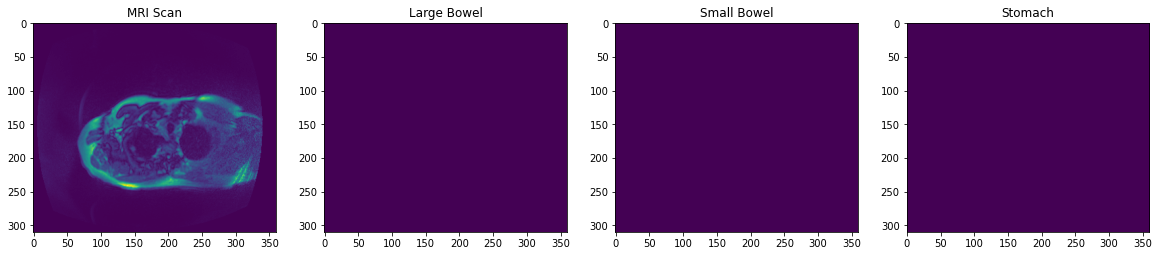

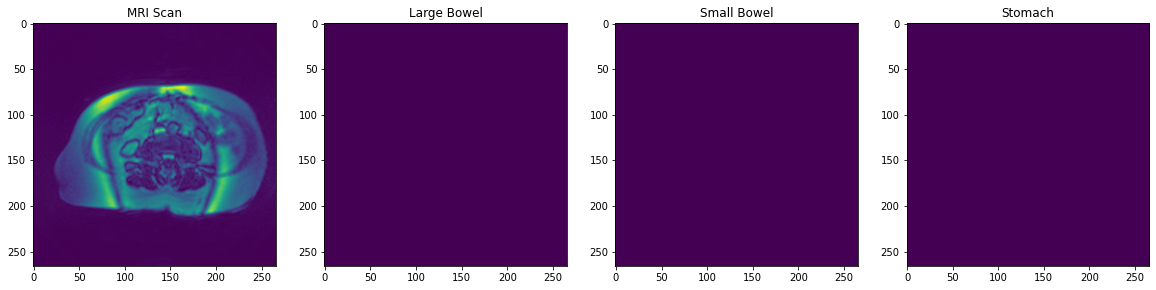

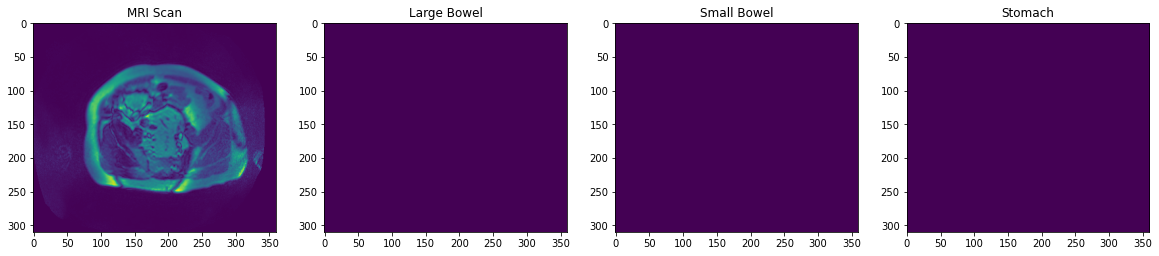

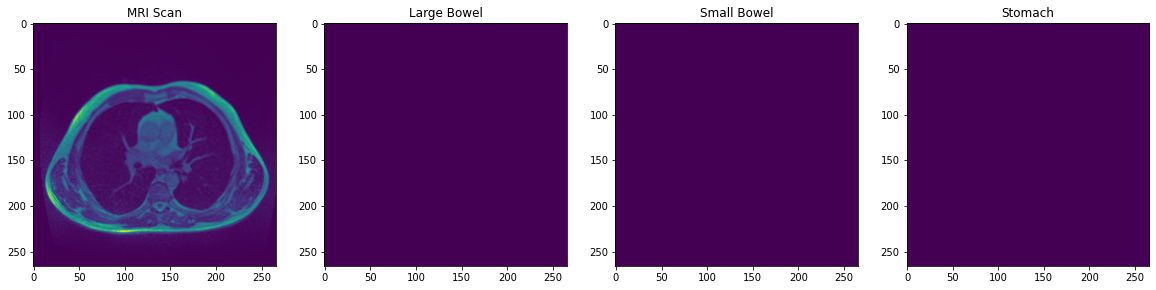

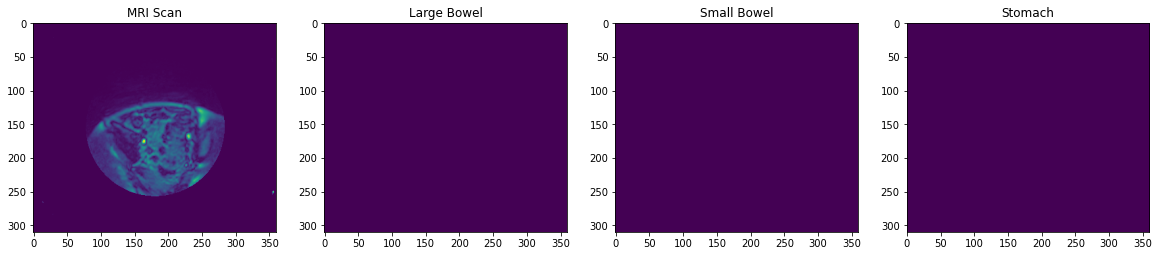

In [29]:
visual(data,5)

In [30]:
def RGBMask(record):
    
    shape = (record['height'], record['width'], 3)
    mask = np.zeros(shape, dtype=np.uint8)
    
    small = mask_from_rle(record['small_bowel'],(record['height'],record['width']))
    large = mask_from_rle(record['large_bowel'],(record['height'],record['width']))
    stomach = mask_from_rle(record['stomach'],(record['height'],record['width']))
    
    mask[...,0] = large
    mask[...,1] = small
    mask[...,2] = stomach
    
    return mask

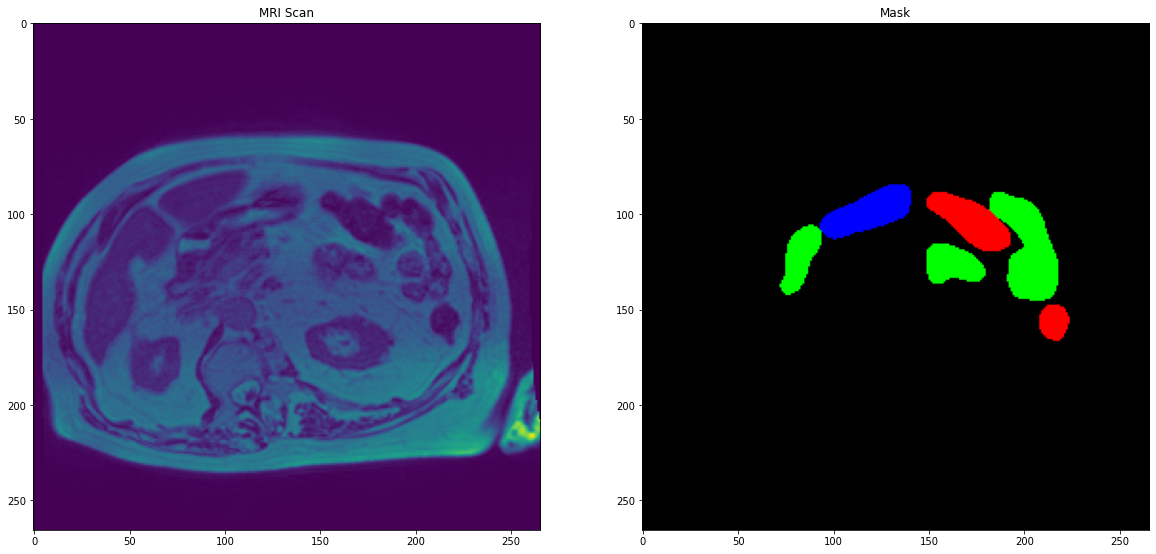

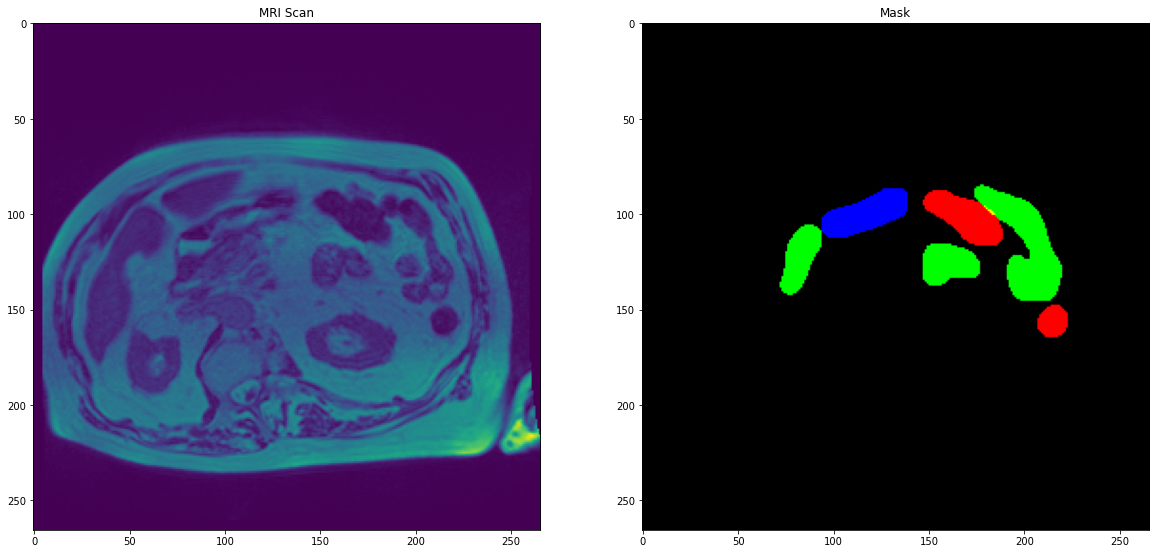

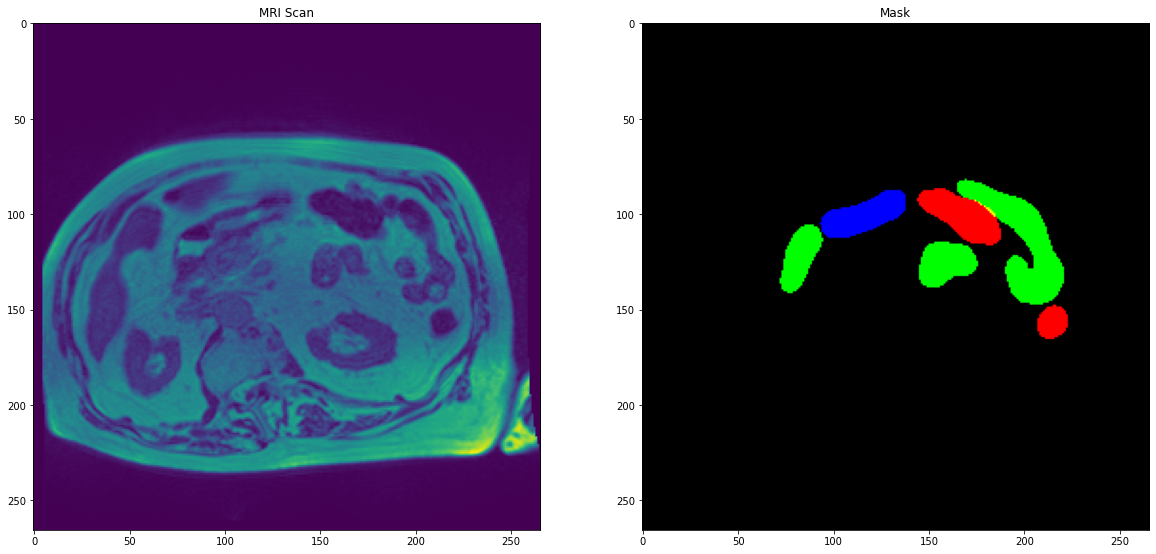

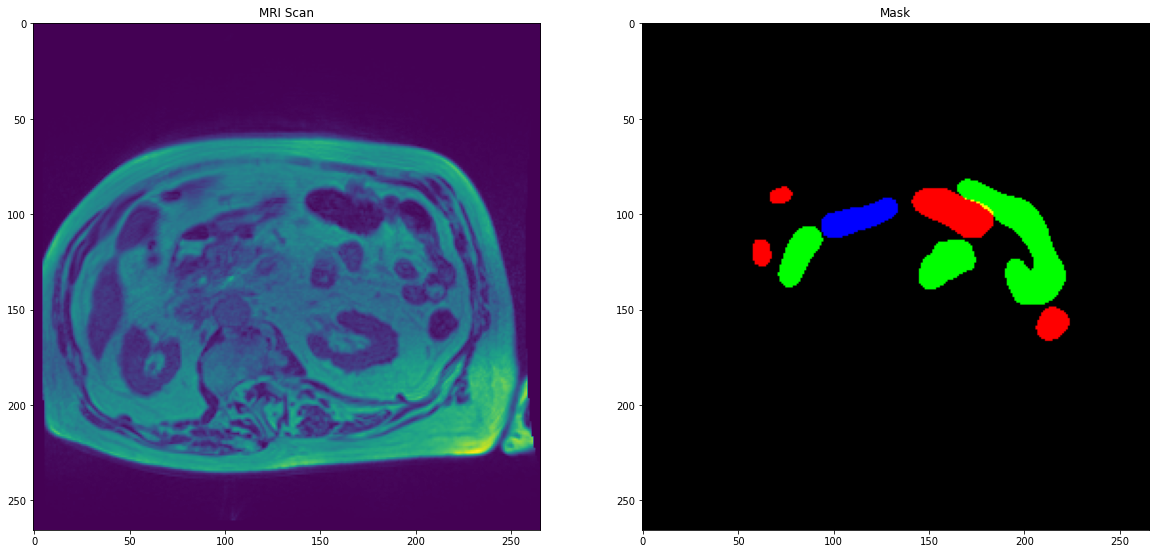

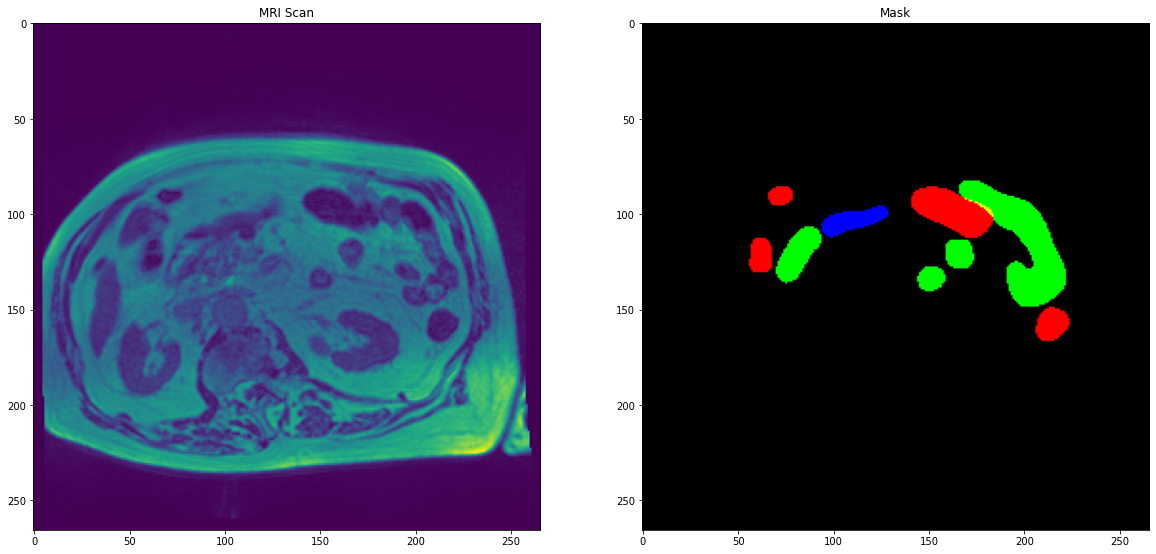

In [31]:
for index in data[data['stomach'].notna()].tail(5).index:
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(read_img(data.loc[index,'filepath']))
    plt.title("MRI Scan")
    plt.subplot(1,2,2)
    plt.imshow(RGBMask(data.loc[index,:]))
    plt.title("Mask")
    plt.show()

In [45]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, image_path, batch_size, 
                 input_size=(256, 256, 3), shuffle=True):
        
        self.df = df.copy()
        self.image_path = image_path
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.n = len(self.df)
        self.indexes = self.df.index
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return (self.n // self.batch_size)
    
    def mask_from_rle(self, rle, shape):
    
        if type(rle) == float: # if nan
            return np.zeros(shape[0] * shape[1], dtype=np.uint8).reshape(shape)

        segm = np.asarray(rle.split(), dtype=int)
        start_point = segm[0::2] - 1
        length_point = segm[1::2]
        end_point = start_point + length_point
        case_mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

        for start, end in zip(start_point, end_point):
            case_mask[start:end] = 255

        case_mask = case_mask.reshape((shape[0], shape[1]))

        return case_mask
    
    def RGBMask(self, record):
    
        shape = (record['height'], record['width'], 3)
        mask = np.zeros(shape, dtype=np.uint8)

        small = mask_from_rle(record['small_bowel'],(record['height'],record['width']))
        large = mask_from_rle(record['large_bowel'],(record['height'],record['width']))
        stomach = mask_from_rle(record['stomach'],(record['height'],record['width']))

        mask[...,0] = large
        mask[...,1] = small
        mask[...,2] = stomach

        return mask
    
    def read_img(self, path):
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype("float32")
        return img
    
    def __getitem__(self,index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X, y = self.__get_data(batch)        
        return X, y
    
    def __get_data(self,batch):
        
        X = []
        y= []
        
        for index, record in batch.iterrows():
            image = read_img(batch.loc[index,self.image_path])
            mask = RGBMask(batch.loc[index,:])
            image = cv2.resize(image, (64,64)) # 64x64 so that training is fast
            mask = cv2.resize(mask, (64,64))

            # image = image[:, :, np.newaxis]
            # image[...,0] = image

            image = image / 255.0
            mask = mask / 255.0
            
            X.append(image)
            y.append(mask)
            
        X = np.array(X)
        y = np.array(y)
        
        return X,y

In [46]:
import plotly.express as px
from plotly.offline import init_notebook_mode

In [47]:
fig = px.bar(data.groupby('case').count().reset_index(), x='case', y='filepath',title='Number of Days Per Case')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

In [48]:
data_with_mask = data.dropna(axis=0, how='all', subset=['large_bowel', 'small_bowel', 'stomach'])
# Using data_with_mask to reduce train data

In [50]:
data_with_mask.shape

(16590, 12)

In [51]:
import random

cases = data_with_mask['case'].unique().tolist()
random.shuffle(cases)
n = len(data_with_mask)
n_cases = len(cases)
n, n_cases

(16590, 85)

In [52]:
train_set = cases[:int(n_cases*0.50)]  # trying to reduce training data
valid_set = cases[int(n_cases*0.50):int(n_cases*0.80)]
test_set = cases[int(n_cases*0.80):]

In [53]:
# train = data[data['case'].isin(train_set)].reset_index(drop=True)
# valid = data[data['case'].isin(valid_set)].reset_index(drop=True)
# test = data[data['case'].isin(test_set)].reset_index(drop=True)  

train = data_with_mask[data_with_mask['case'].isin(train_set)].reset_index(drop=True)
valid = data_with_mask[data_with_mask['case'].isin(valid_set)].reset_index(drop=True)
test = data_with_mask[data_with_mask['case'].isin(test_set)].reset_index(drop=True)  

In [41]:
train.shape, test.shape, valid.shape, len(train_set), len(test_set), len(valid_set)

((8990, 12), (2995, 12), (4605, 12), 42, 17, 26)

In [57]:
train_generator = CustomDataGenerator(train, 'filepath', batch_size=32)
valid_generator = CustomDataGenerator(valid, 'filepath', batch_size=32)
test_generator = CustomDataGenerator(test, 'filepath', batch_size=32, shuffle=False)

In [58]:
generate = train_generator[0]

In [59]:
generate[0].shape, generate[1].shape

((32, 64, 64), (32, 64, 64, 3))

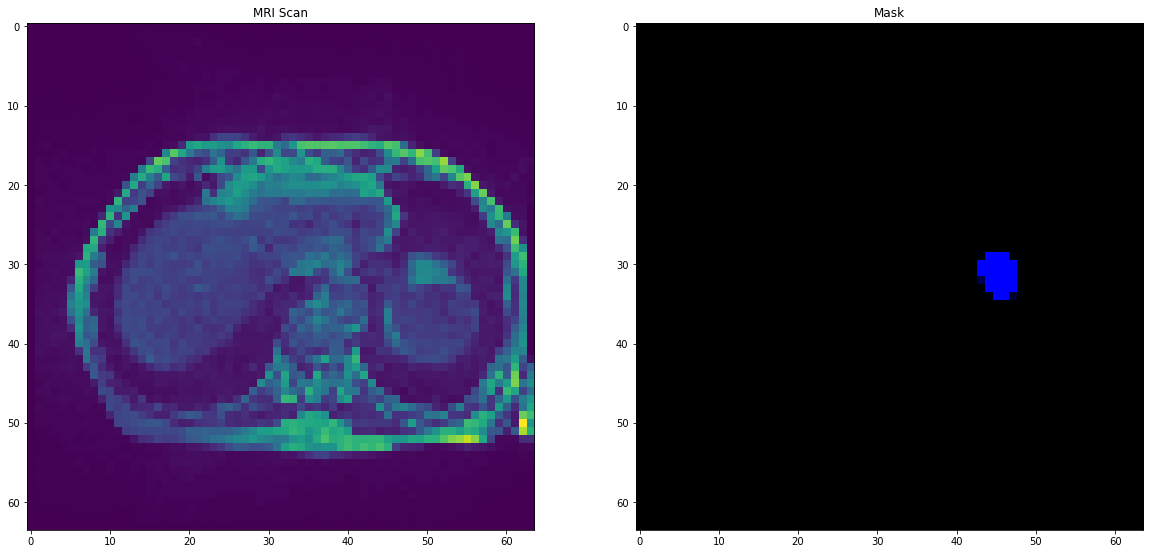

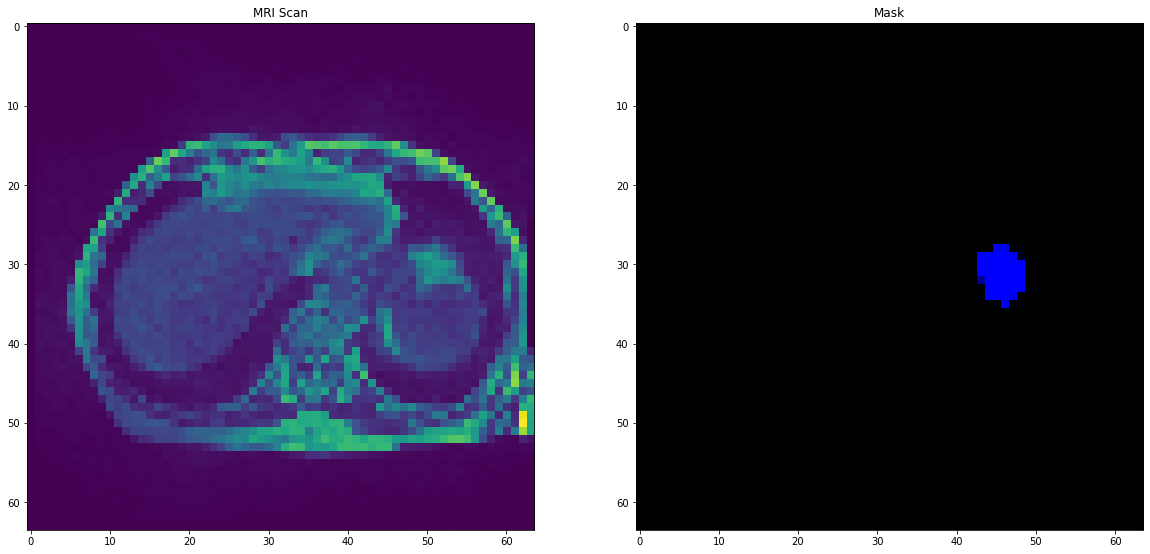

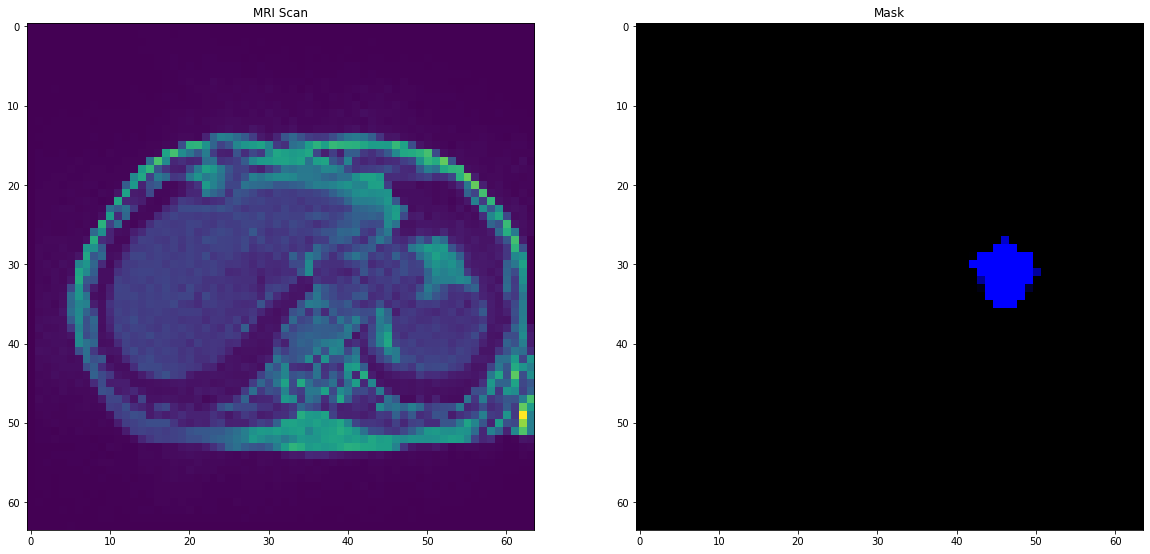

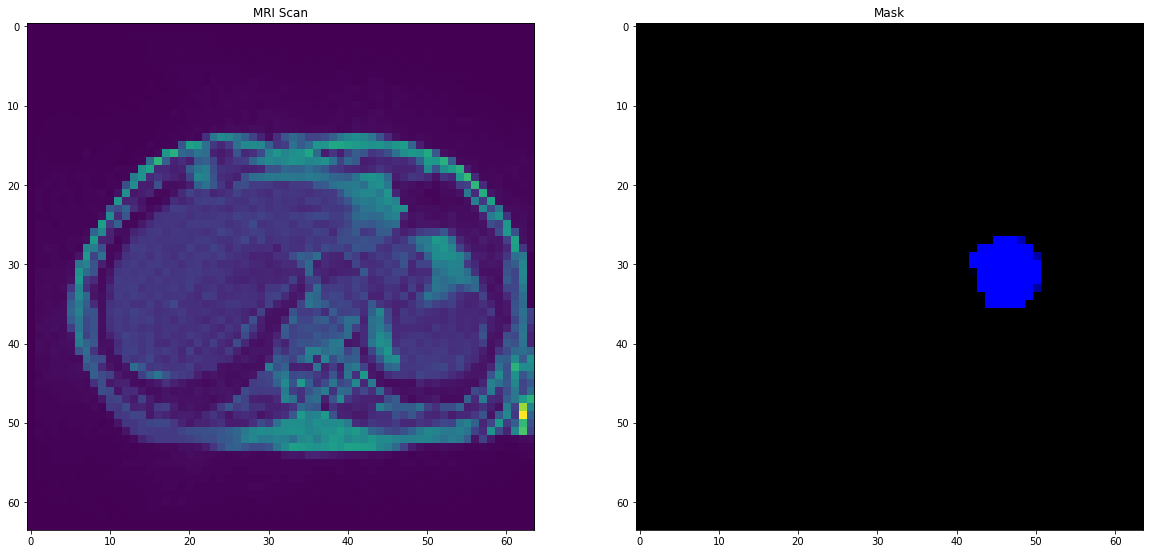

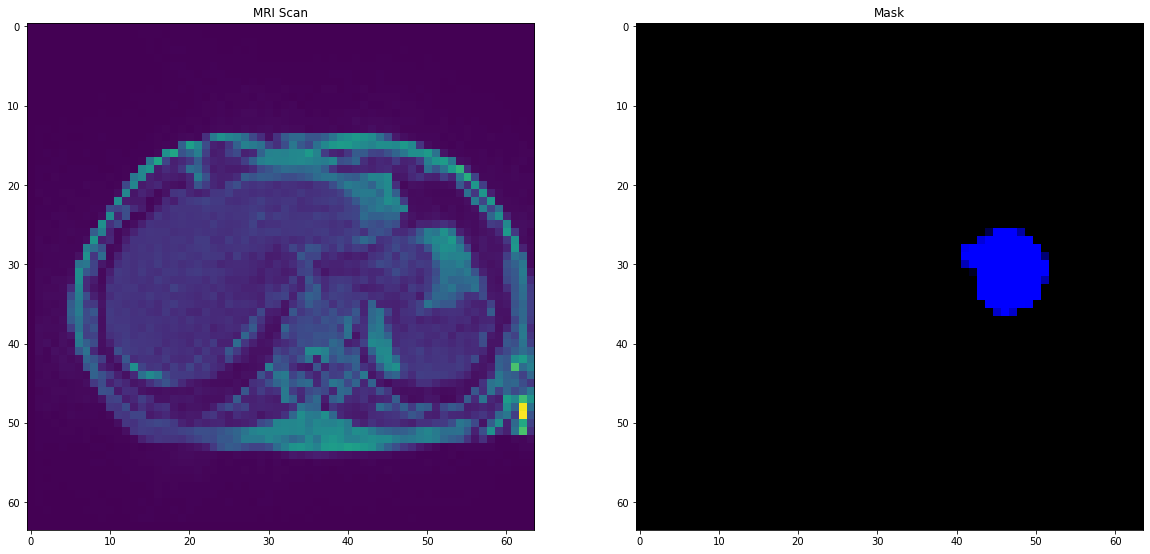

In [60]:
for i in range(5):
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(generate[0][i])
    plt.title("MRI Scan")
    plt.subplot(1,2,2)
    plt.imshow(generate[1][i])
    plt.title("Mask")
    plt.show()

In [61]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    #First layer 
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [62]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    # c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    # p2 = MaxPooling2D((2, 2))(c2)
    # p2 = Dropout(dropout)(p2)

    # c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    # p3 = MaxPooling2D((2, 2))(c3)
    # p3 = Dropout(dropout)(p3)

    # c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    # p4 = MaxPooling2D((2, 2))(c4)
    # p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p1, n_filters = n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    # u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    # u6 = concatenate([u6, c4])
    # u6 = Dropout(dropout)(u6)
    # c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    # u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    # u7 = concatenate([u7, c3])
    # u7 = Dropout(dropout)(u7)
    # c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    # u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c5)
    # u8 = concatenate([u8, c2])
    # u8 = Dropout(dropout)(u8)
    # c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(3, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [63]:
im_width = 64
im_height = 64

In [64]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=4, dropout=0.05, batchnorm=False)
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])


In [65]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(train_generator, epochs=1
                    # , callbacks=callbacks
                    # , validation_data=valid_generator
                    )

 20/247 [=>............................] - ETA: 1:40:47 - loss: 0.0939 - accuracy: 0.5683